In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
from scipy.signal import butter, lfilter, welch, square  # for signal filtering
from utilis import *
from args_emg import args as my_args

In [4]:
fs = 200
VERBOSE = True
data_dir = "dataset/Roshambo/"
classes = ["rock", "paper", "scissor"]
classes_dict = {"rock": 0, "paper": 1, "scissor": 2}
classes_inv = {v: k for k, v in classes_dict.items()}

class Person(object):
        def __init__(self, name, emg, ann, classes=classes):
            self.name = name
            self.emg = emg
            self.ann = ann
            self.trials = {c: [] for c in classes}
            self.begs = {c: [] for c in classes}
            self.ends = {c: [] for c in classes}
            self.x = {c: [] for c in classes}
            self.y = {c: [] for c in classes}
            self.ts = {c: [] for c in classes}
            self.pol = {c: [] for c in classes}
            self.emg_spks = {c: [] for c in classes}
            self.spk_trials = {c: [] for c in classes}

subjects = {}
names = sorted([name for name in os.listdir(data_dir) if "emg" in name])

for name in names:
    _emg = np.load(data_dir + "{}".format(name)).astype("float32")
    _ann = np.concatenate(
        [
            np.array(["none"]),
            np.load(data_dir + "{}".format(name.replace("emg", "ann")))[:-1],
        ]
    )
    subjects["_".join(name.split("_")[:2])] = Person(
        name.split("_")[0], _emg, _ann, classes=classes
    )
    print(
        "Loaded {}: EMG = [{}] // ANN = [{}]".format(
            "_".join(name.split("_")[:2]), _emg.shape, len(_ann)
        )
    )
for name, data in subjects.items():
    for _class in classes:
        _annotation = np.float32(data.ann == _class)
        derivative = np.diff(_annotation) / 1.0
        begins = np.where(derivative == 1)[0]
        ends = np.where(derivative == -1)[0]
        for b, e in zip(begins, ends):
            _trials = data.emg[b:e]
            data.trials[_class].append(_trials / np.std(_trials))
            data.begs[_class].append(b)
            data.ends[_class].append(e)
print("Done sorting trials!")

# check that we get 5 trials per subject per gesture
for sub_name, sub_data in subjects.items():
    for _class, trials in sub_data.trials.items():
        assert len(trials) == 5, "Something wrong with the number of trials!"
print("All good!")

Loaded subject01_session01: EMG = [(8962, 8)] // ANN = [8962]
Loaded subject01_session02: EMG = [(8933, 8)] // ANN = [8933]
Loaded subject01_session03: EMG = [(8989, 8)] // ANN = [8989]
Loaded subject02_session01: EMG = [(8990, 8)] // ANN = [8990]
Loaded subject02_session02: EMG = [(8985, 8)] // ANN = [8985]
Loaded subject02_session03: EMG = [(8975, 8)] // ANN = [8975]
Loaded subject03_session01: EMG = [(8976, 8)] // ANN = [8976]
Loaded subject03_session02: EMG = [(8949, 8)] // ANN = [8949]
Loaded subject03_session03: EMG = [(8981, 8)] // ANN = [8981]
Loaded subject04_session01: EMG = [(8953, 8)] // ANN = [8953]
Loaded subject04_session02: EMG = [(8943, 8)] // ANN = [8943]
Loaded subject04_session03: EMG = [(8953, 8)] // ANN = [8953]
Loaded subject05_session01: EMG = [(9185, 8)] // ANN = [9185]
Loaded subject05_session02: EMG = [(9146, 8)] // ANN = [9146]
Loaded subject05_session03: EMG = [(9150, 8)] // ANN = [9150]
Loaded subject06_session01: EMG = [(8984, 8)] // ANN = [8984]
Loaded s

Number of samples in dataset:
450
450
Class labels:
[0, 1, 2]
Subjects : 
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Sessions : 
[1, 2, 3]
Trials per session : 
[0, 1, 2, 3, 4]
Average spiking rate
115.03354166666665


Text(0, 0.5, 'Amplitude')

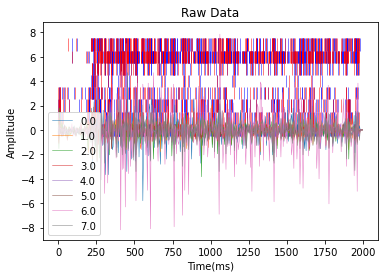

In [6]:
X_EMG = []
Y_EMG = []
SUB_EMG = []
SES_EMG = []
TRI_EMG = []

for name, data in subjects.items():
    for gesture in classes:
        for trial in range(5):
            X_EMG.append(data.trials[gesture][trial])
            Y_EMG.append(classes_dict[gesture])
            SUB_EMG.append(int(name[7:9]))
            SES_EMG.append(int(name[17:19]))
            TRI_EMG.append(trial)
X_EMG = np.array(X_EMG)
Y_EMG = np.array(Y_EMG)
SUB_EMG = np.array(SUB_EMG)
SES_EMG = np.array(SES_EMG)
TRI_EMG = np.array(TRI_EMG)

# X_EMG_uniform is a time series data array with length of 400. The initial segments are about 397, 493 etc which
# makes it incompatible in some cases where uniform input is desired.

nb_trials = X_EMG.shape[0]
len_trial = fs * 2  # 2 seconds of trial, sampling rate is 200
nb_channels = 8
X_EMG_uniform = np.ones((nb_trials, len_trial, nb_channels))
for i in range(len(X_EMG)):
    trial_length = X_EMG[i].shape[0]
    if trial_length > len_trial:
        X_EMG_uniform[i] = X_EMG[i][0:len_trial]
    elif trial_length < len_trial:
        short = len_trial - trial_length
        pad = np.zeros((short, nb_channels))
        X_EMG_uniform[i] = np.append(X_EMG[i], pad, axis=0)
    else:
        X_EMG_uniform[i] = X_EMG[i]
# print(len(X_EMG))
print("Number of samples in dataset:")
print(len(X_EMG_uniform))
print(len(Y_EMG))
print("Class labels:")
print(list(set(Y_EMG)))
print("Subjects : ")
print(list(set(SUB_EMG)))
print("Sessions : ")
print(list(set(SES_EMG)))
print("Trials per session : ")
print(list(set(TRI_EMG)))

# Take session 0,1 as train and session 2 as test.

X_EMG_Train = []
Y_EMG_Train = []
X_EMG_Test = []
Y_EMG_Test = []
for i in range(len(Y_EMG)):
    if (SES_EMG[i]) == 1:
        X_EMG_Test.append(X_EMG_uniform[i])
        Y_EMG_Test.append(Y_EMG[i])
    else:
        X_EMG_Train.append(X_EMG_uniform[i])
        Y_EMG_Train.append(Y_EMG[i])
interpfact = 5
refractory_period = 1  # in ms
th_up = 0.5
th_dn = 0.5
n_ch = 8
fs = 200

# Generate the training data
spike_times_train_up = []
spike_times_train_dn = []
for i in range(len(X_EMG_Train)):
    spk_up, spk_dn = gen_spike_time(
        time_series_data=X_EMG_Train[i],
        interpfact=interpfact,
        fs=fs,
        th_up=th_up,
        th_dn=th_dn,
        refractory_period=refractory_period,
    )
    spike_times_train_up.append(spk_up)
    spike_times_train_dn.append(spk_dn)
# Generate the test data
spike_times_test_up = []
spike_times_test_dn = []
for i in range(len(X_EMG_Test)):
    spk_up, spk_dn = gen_spike_time(
        time_series_data=X_EMG_Test[i],
        interpfact=interpfact,
        fs=fs,
        th_up=th_up,
        th_dn=th_dn,
        refractory_period=refractory_period,
    )
    spike_times_test_up.append(spk_up)
    spike_times_test_dn.append(spk_dn)

rate_up_test = gen_spike_rate(spike_times_test_up)
rate_dn_test = gen_spike_rate(spike_times_test_up)
rate_up_train = gen_spike_rate(spike_times_train_up)
rate_dn_train = gen_spike_rate(spike_times_train_up)
avg_spike_rate = (rate_up_test+rate_dn_test+rate_up_train+rate_dn_train)/4
print("Average spiking rate")
print(avg_spike_rate)


_t = np.arange(
    0, 2000, 5
)  # Time array of 2000ms for the 200 samples per second. For ploting purpose.
_t_spike = np.arange(0, 2000, 1)  # Time array for defining the X axis of graph.

# Plot a up segment
plt.eventplot(spike_times_test_up[1], color=[0, 0, 1], linewidth=0.5)
plt.xlabel("Time(ms)")
plt.ylabel("Channel")
plt.title("Spike raster plot for up channel")

# Plot a dn segment
plt.eventplot(spike_times_test_dn[1], color=[1, 0, 0], linewidth=0.5)
plt.xlabel("Time(ms)")
plt.ylabel("Channel")
plt.title("Spike raster plot for down channel")

channels = np.linspace(0, 7, num=8)
plt.plot(_t, X_EMG_Test[1], linewidth=0.5)
plt.legend(channels)
plt.title("Raw Data")
plt.xlabel("Time(ms)")
plt.ylabel("Amplitude")

In [13]:
len(spike_times_test_up[1][2])

172

In [17]:
X_EMG_Test[1][:,0].shape

(400,)

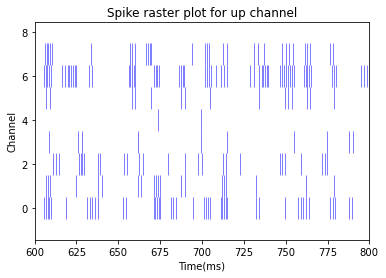

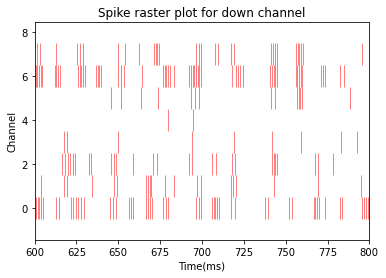

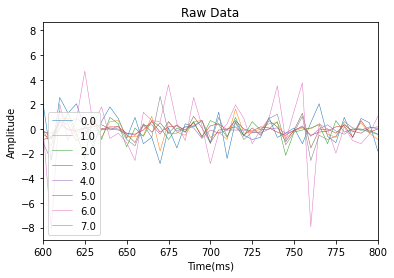

In [77]:
_t = np.arange(
    0, 2000, 5
)  # Time array of 2000ms for the 200 samples per second. For ploting purpose.
_t_spike = np.arange(0, 2000, 1)  # Time array for defining the X axis of graph.

# Plot a up segment
plt.eventplot(spike_times_test_up[1], color=[0, 0, 1], linewidth=0.5)
plt.xlabel("Time(ms)")
plt.ylabel("Channel")
plt.title("Spike raster plot for up channel")
plt.xlim([600, 800])
plt.savefig("up.svg", format="svg")

plt.show()
plt.clf()
# Plot a dn segment
plt.eventplot(spike_times_test_dn[1], color=[1, 0, 0], linewidth=0.5)
plt.xlabel("Time(ms)")
plt.ylabel("Channel")
plt.title("Spike raster plot for down channel")
plt.xlim([600, 800])

plt.savefig("dn.svg", format="svg")


plt.show()
plt.clf()

channels = np.linspace(0, 7, num=8)
plt.plot(_t, X_EMG_Test[1], linewidth=0.5)
plt.legend(channels)
plt.title("Raw Data")
plt.xlabel("Time(ms)")
plt.ylabel("Amplitude")
plt.xlim([600, 800])
# plt.ylim([-4, 4])

plt.savefig("signal.svg", format="svg")




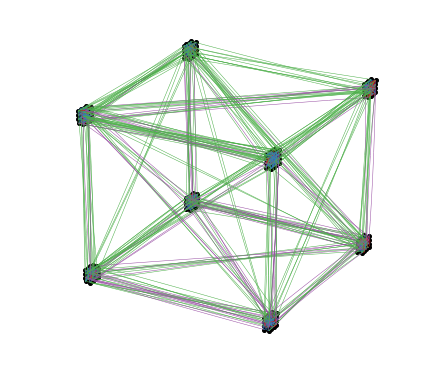

In [73]:
# Copyright (c) 2012-2018, NECOTIS
# All rights reserved.
#
# Redistribution and use in source and binary forms, with or without modification,
# are permitted provided that the following conditions are met:
#
#  - Redistributions of source code must retain the above copyright notice,
#    this list of conditions and the following disclaimer.
#  - Redistributions in binary form must reproduce the above copyright notice,
#    this list of conditions and the following disclaimer in the documentation
#    and/or other materials provided with the distribution.
#  - Neither the name of the copyright holder nor the names of its contributors
#    may be used to endorse or promote products derived from this software
#    without specific prior written permission.
#
# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND
# ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED
# WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED.
# IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT,
# INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT
# NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA,
# OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY,
# WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE)
# ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE
# POSSIBILITY OF SUCH DAMAGE.




# Authors: Simon Brodeur, Jean Rouat (advisor)
# Date: April 18th, 2019
# Organization: Groupe de recherche en Neurosciences Computationnelles et Traitement Intelligent des Signaux (NECOTIS),
# Université de Sherbrooke, Canada

import logging
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import axes3d, art3d
from brian2.units import ms, um, meter, Hz
from brian2.groups import NeuronGroup
from brian2.synapses.synapses import Synapses
from brian2.input.binomial import BinomialFunction
from brian2.core.variables import Variables
from brian2.groups.group import CodeRunner
from brian2.units.fundamentalunits import check_units

logger = logging.getLogger(__name__)


# Adapted from Brian2 class: PoissonInput
class CriticalSpontaneousActivity(CodeRunner):
    '''
    CriticalSpontaneousActivity(target, rate, when='synapses', order=0)

    Adds independent Poisson input to a target variable of a `Group`. For large
    numbers of inputs, this is much more efficient than creating a
    `PoissonGroup`. The synaptic events are generated randomly during the
    simulation and are not preloaded and stored in memory. All the inputs must
    target the same variable, have the same frequency and same synaptic weight.
    All neurons in the target `Group` receive independent realizations of
    Poisson spike trains.

    Parameters
    ----------
    target : `Group`
        The group that is targeted by this input.
    rate : `Quantity`
        The rate of each of the inputs
    when : str, optional
        When to update the target variable during a time step. Defaults to
        the `synapses` scheduling slot.
    order : int, optional
        The priority of of the update compared to other operations occurring at
        the same time step and in the same scheduling slot. Defaults to 0.

    '''
    @check_units(rate=Hz)
    def __init__(self, target, rate, when='synapses',
                 order=0):
        self._rate = rate
        binomial_sampling = BinomialFunction(1, rate * target.clock.dt,
                                             name='poissoninput_binomial*')

        # NOTE: elicit a spike, but also increase the total input contribution for
        #       what was needed to reach the threshold.
        code = '''
        eps = 0.01
        delta_v_to_vt = {binomial}()*(vt - v) * int(not_refractory)
        c_in_tot += int(delta_v_to_vt > 0) * delta_v_to_vt
        v += int(delta_v_to_vt > 0) * (delta_v_to_vt + eps)
        '''.format(binomial=binomial_sampling.name)
        self._stored_dt = target.dt_[:]  # make a copy
        # FIXME: we need an explicit reference here for on-the-fly subgroups
        # For example: PoissonInput(group[:N], ...)
        self._group = target
        CodeRunner.__init__(self,
                            group=target,
                            template='stateupdate',
                            code=code,
                            user_code='',
                            when=when,
                            order=order,
                            name='poissoninput*',
                            clock=target.clock
                            )
        self.variables = Variables(self)
        self.variables._add_variable(binomial_sampling.name, binomial_sampling)

    rate = property(fget=lambda self: self._rate,
                    doc='The rate of each input')

    def before_run(self, run_namespace):
        if self._group.dt_ != self._stored_dt:
            raise NotImplementedError('The dt used for simulating %s changed '
                                      'after the PoissonInput source was '
                                      'created.' % self.group.name)
        CodeRunner.before_run(self, run_namespace=run_namespace)


def quadraticBezierPath(posA, posB, nstep=8, controlDist=0.1, controlDim=[0, 1, 2]):
    segments = []

    vecP1 = posB - posA
    if np.linalg.norm(vecP1) == 0.0:
        raise Exception('Same start and end vertices!')

    vecP2 = np.array([0, 0, 0])
    vecP2[controlDim[2]] = 1.0
    vecC = np.cross(vecP1, vecP2)
    if np.linalg.norm(vecC) == 0.0:
        # The vectors are colinear so change the reference plane
        vecP2 = np.array([0, 0, 0])
        vecP2[controlDim[1]] = 1.0
    vecC = np.cross(vecP1, vecP2)
    vecC = vecC / np.linalg.norm(vecC) * controlDist

    posD = posA + (posB - posA) / 2.0
    posC = posD + vecC

    for t in np.linspace(0, 1.0, nstep):
        pos = posA * (1 - t) ** 2 + posB * t ** 2 + posC * 2 * t * (1 - t)
        segments.append(pos)
    return segments


def createNeuronGroup(N, refractory=5 * ms, tau_vt=50 * ms, vti=0.1, srate=0.0 * Hz, soft_reset=False):

    # Leaky integrate-and-fire neuron with adaptive threshold
    eqs = '''
        dv/dt = -(v-v0)/tau: 1  (unless refractory) # membrane potential
        dvt/dt = -(vt-vt0)*adaptation/tau_vt : 1               # adaptive threshold
        next_layer_last_fire : second       # time of firing of any of the post neuron
        tau : second                          # time constant for membrane potential
        tau_vt : second                       # time constant for adaptive threshold
        v0 : 1                                # membrane potential reset value
        vt0 : 1                               # adaptive threshold reset value
        vti : 1                               # adaptive threshold increment

        cbf : 1               # last estimation of the target branching factor
        c_in_tot : 1          # estimation of total input contributions
        c_out_tot : 1         # estimation of total output contributions
        c_out_ref : 1         # target output contribution

        x : meter             # position of the neuron
        y : meter
        z : meter

        midx : 1        # macrocolumn index inside the microcircuit
        mmidx : 1       # minicolumn index inside the microcircuit

        ntype : 1       # type of the neuron (excitatory/inhibitory)
        adaptation : 1  # type of neuron (Adaptive threshold)
    '''

    if soft_reset:
        reset = '''
        v -= vt     # soft-reset membrane potential
        vt += vti*adaptation   # increment adaptive threshold
        '''
    else:
        reset = '''
        v = v0      # reset membrane potential
        vt += vti*adaptation   # increment adaptive threshold
        '''

    # Spike detection
    threshold = 'v > vt'
    G = NeuronGroup(N, model=eqs, reset=reset, threshold=threshold,
                    refractory=refractory, method='exact')

    if srate > 0.0:
        # Noise model
        noise = CriticalSpontaneousActivity(G, srate)
        G.add_attribute('noise')
        G.noise = noise
        G.contained_objects.append(G.noise)

    # Configure neuron state variables initial values
    G.v = 0.0
    G.tau = '15*ms + 10*ms * rand()'
    G.tau_vt = tau_vt
    G.vt0 = '1.0 + 1.0 * rand()'
    G.v0 = '0'
    G.vt = 1.0
    G.vti = vti

    # Configure initial state for learning rule
    G.cbf = 0.0
    G.c_in_tot = 0.0
    G.c_out_tot = 0.0
    G.c_out_ref = 1.0

    G.ntype = 1.0  # Excitatory neuron

    return G


def createCriticalStdpSynapses(G, stdp_tau=10 , stdp_apre=1e-4):

    # taupre = 10 * ms   # Time constant for potentiation
    wmax=1
    taupre = stdp_tau * ms
    taupost = taupre   # Time constant for depression
    dApre = stdp_apre
    dApost = -dApre * taupre / taupost * 1.05
    dApost *= wmax
    dApre *= wmax

    # Configure synaptic connections
    eqs = '''
    dApre/dt = -Apre / taupre : 1 (event-driven)            # STDP presynaptic trace
    dApost/dt = -Apost / taupost : 1 (event-driven)         # STDP postsynaptic trace

    w : 1                                # synaptic contribution per spike
    wmax : 1                         # Maximum weight
    alpha : 1                            # learning rate
    freeze_time_ms : 1
    plastic : boolean (shared)           # switch to activate/disable plasticity
    '''

    # From: Brodeur, S., & Rouat, J. (2012). Regulation toward Self-organized Criticality in a Recurrent Spiking Neural Reservoir.
    #       In A. E. Villa, W. Duch, P. Érdi, F. Masulli, & G. Palm (Eds.), Artificial Neural Networks and Machine Learning -- ICANN 2012 (Vol. 7552, pp. 547–554). Springer.
    # see Algorithm 1: Local unsupervised learning rule for self-organized
    # criticality
    on_pre = {  
        # Step 1: Update estimations of local input contributions
        'pre_transmission': '''
            v_post += w  * ntype_pre * int(not_refractory_post)*int((t - next_layer_last_fire_pre)>freeze_time_ms*ms)                                                # Add contribution of the presynaptic spike to the dynamic of the post-synaptic neuron
            c_in_tot_post += w * ntype_pre * int(ntype_pre > 0) * int(not_refractory_post)                     # Update estimations of local input contributions to postsynaptic neurons
        ''',
        # Step 3 and 4: Calculate the error on the target contribution, and update postsynaptic weights to reduce the error
        'pre_plasticity_critical': '''
            cbf_pre = c_out_tot_pre                                                                                                       # Store current estimate of the target branching factor
            e = (c_out_ref_pre - c_out_tot_pre)                                                                                           # Calculate the error on the target contribution
            w = clip(w + int(plastic) * alpha * (e / N_outgoing) * int(ntype_pre > 0), 0.01, wmax)                                         # Update postsynaptic weights to reduce the error
        ''',
        # STDP potentiation
        'pre_plasticity_stdp': '''
            Apre += dApre
            w = clip(w + Apost * int(ntype_pre > 0), 0.01, wmax)
        ''',
        # Step 5: Reset state variables to accumulate contributions for another interspike interval
        'pre_reset': '''
            c_in_tot_pre = 0.0
            c_out_tot_pre = 0.0
        '''
    }

    on_post = {
        # Step 2: Update estimations of local output contributions
        # NOTE: The case c_in_tot_post = 0 can happen if spontaneous activity elicited a postsynaptic spike.
        # In that case, c_out_tot_pre will be zero (no contribution).
        'post_feedback': '''
            next_layer_last_fire_pre = t
            eps = 1e-10
            c_out_tot_pre += (w * int(ntype_pre > 0) / (c_in_tot_post)) * int(lastspike_pre > 0.0 * ms) * exp(-(t - lastspike_pre)/ tau_post)               # Update estimations of local output contributions in presynaptic neurons, with ponderation scheme to favor recently active presynaptic neurons.
        ''',
        # STDP depression
        'post_plasticity_stdp': '''
            Apost += dApost
            w = clip(w + Apre * int(ntype_pre > 0), 0.01, wmax)
        ''',
        # Step 5: Reset state variables to accumulate contributions for another interspike interval
        # NOTE: we need this in case the postsynaptic neuron has no outgoing connections
        'post_reset': '''
            c_in_tot_post = 0.0
        '''
    }

    S = Synapses(G, G, model=eqs, on_pre=on_pre, on_post=on_post, namespace={'taupre': taupre, 'taupost': taupost,
                                                                             'wmax': wmax, 'dApre': dApre, 'dApost': dApost})

    # NOTE: the execution order is important
    S.pre_transmission.order = 1
    S.post_feedback.order = 2
    S.pre_plasticity_critical.order = 3
    S.pre_plasticity_stdp.order = 3
    S.post_plasticity_stdp.order = 4
    S.pre_reset.order = 4
    S.post_reset.order = 5

    return S


def createCriticalSynapses(G):
 

    # Configure synaptic connections
    eqs = '''
    w : 1                                # synaptic contribution per spike
    freeze_time_ms : 1
    wmax : 1                         # Maximum weight
    alpha : 1                            # learning rate
    plastic : boolean (shared)           # switch to activate/disable plasticity
    '''

    # From: Brodeur, S., & Rouat, J. (2012). Regulation toward Self-organized Criticality in a Recurrent Spiking Neural Reservoir.
    #       In A. E. Villa, W. Duch, P. Érdi, F. Masulli, & G. Palm (Eds.), Artificial Neural Networks and Machine Learning -- ICANN 2012 (Vol. 7552, pp. 547–554). Springer.
    # see Algorithm 1: Local unsupervised learning rule for self-organized
    # criticality
    on_pre = {  
        # Step 1: Update estimations of local input contributions
        'pre_transmission': '''
            v_post += w  * ntype_pre * int(not_refractory_post)*int((t - next_layer_last_fire_pre)>freeze_time_ms*ms)                                              # Add contribution of the presynaptic spike to the dynamic of the post-synaptic neuron
            c_in_tot_post += w * ntype_pre * int(ntype_pre > 0) * int(not_refractory_post)                     # Update estimations of local input contributions to postsynaptic neurons
        ''',
        # Step 3 and 4: Calculate the error on the target contribution, and update postsynaptic weights to reduce the error
        'pre_plasticity': '''
            cbf_pre = c_out_tot_pre                                                                                                       # Store current estimate of the target branching factor
            e = (c_out_ref_pre - c_out_tot_pre)                                                                                           # Calculate the error on the target contribution
            w = clip(w + int(plastic) * alpha * (e / N_outgoing) * exp(-(t - lastspike_post)/tau_pre) * int(ntype_pre > 0), 0, wmax)    # Update postsynaptic weights to reduce the error, with ponderation scheme to favor recently active postsynaptic neurons
        ''',
        # Step 5: Reset state variables to accumulate contributions for another interspike interval
        'pre_reset': '''
            c_in_tot_pre = 0.0
            c_out_tot_pre = 0.0
        '''
    }

    on_post = {
        # Step 2: Update estimations of local output contributions
        # NOTE: The case c_in_tot_post = 0 can happen if spontaneous activity elicited a postsynaptic spike.
        # In that case, c_out_tot_pre will be zero (no contribution).
        'post_feedback': '''
            eps = 1e-10
            c_out_tot_pre += (w * int(ntype_pre > 0) * int(c_in_tot_post > 0) / (c_in_tot_post + eps)) * int(lastspike_pre > 0.0 * ms) * exp(-(t - lastspike_pre)/ tau_post)               # Update estimations of local output contributions in presynaptic neurons, with ponderation scheme to favor recently active presynaptic neurons.
            next_layer_last_fire_pre = t
        ''',
        # Step 5: Reset state variables to accumulate contributions for another interspike interval
        # NOTE: we need this in case the postsynaptic neuron has no outgoing connections
        'post_reset': '''
            c_in_tot_post = 0.0
        '''
    }

    S = Synapses(G, G, model=eqs, on_pre=on_pre, on_post=on_post)

    # NOTE: the execution order is important
    S.pre_transmission.order = 1
    S.post_feedback.order = 2
    S.pre_plasticity.order = 3
    S.pre_reset.order = 4
    S.post_reset.order = 5

    return S


# TODO: make a subclass of BrianObject, and store all in _contained_objects member
class Microcircuit(object):
    '''
    Microcircuit
    '''
    # intracolumnar_sparseness=635
    # neuron_spacing=40
    # p_max=0.11
    # minicolumn_spacing=1460

    def __init__(self, connectivity='small-world',
                 macrocolumnShape=[2, 2, 1], minicolumnShape=[5, 5, 1], minicolumnSpacing=1460 * um,
                 neuronSpacing=40 * um, p_max=0.1, srate=0.0 * Hz, excitatoryProb=0.8, delay=0.0 * ms,
                 withSTDP=False, soft_reset=False, adaptiveProbab=1, stdp_tau=10 , stdp_apre=1e-4, wmax=1, wmin=0.00,
                 winitmin=0.01, winitmax=1, refractory=1, connectivity_matrix=np.zeros((100, 100))):

        self.__dict__.update(macrocolumnShape=macrocolumnShape, minicolumnShape=minicolumnShape,
                             minicolumnSpacing=minicolumnSpacing, neuronSpacing=neuronSpacing)

        # Create the microcircuit
        logger.debug('Creating the microcircuit...')
        self.nbMinicolumns = np.prod(self.macrocolumnShape)
        self.nbNeuronsMinicolumn = np.prod(self.minicolumnShape)
        self.nbNeuronsTotal = self.nbNeuronsMinicolumn * self.nbMinicolumns

        self.G = createNeuronGroup(self.nbNeuronsTotal, vti=0.1, srate=srate, soft_reset=soft_reset, refractory=refractory * ms)

        # Set the 3D coordinates of the neurons
        # Loop over macrocolums
        positions = []
        macrocolumIndices = []
        minicolumIndices = []
        for im in range(self.macrocolumnShape[0]):
            for jm in range(self.macrocolumnShape[1]):
                for km in range(self.macrocolumnShape[2]):
                    # Loop over minicolums
                    for i in range(self.minicolumnShape[0]):
                        for j in range(self.minicolumnShape[1]):
                            for k in range(self.minicolumnShape[2]):
                                xn = float(
                                    im * (self.minicolumnShape[0]) + i) * self.neuronSpacing
                                yn = float(
                                    jm * (self.minicolumnShape[1]) + j) * self.neuronSpacing
                                zn = float(
                                    km * (self.minicolumnShape[2]) + k) * self.neuronSpacing
                                if connectivity == 'small-world':
                                    xn += im * minicolumnSpacing
                                    yn += jm * minicolumnSpacing
                                    zn += km * minicolumnSpacing
                                positions.append([xn, yn, zn])
                                macrocolumIndices.append(
                                    im + jm * self.macrocolumnShape[0] + km * self.macrocolumnShape[0] * self.macrocolumnShape[1])
                                minicolumIndices.append(
                                    i + j * self.minicolumnShape[0] + k * self.minicolumnShape[0] * self.minicolumnShape[1])
        positions = np.array(positions, dtype=np.float32)
        macrocolumIndices = np.array(macrocolumIndices, dtype=np.int)
        minicolumIndices = np.array(minicolumIndices, dtype=np.int)

        # Configure neuron state variables for storing 3D absolute positions
        self.G.x = positions[:, 0] * meter
        self.G.y = positions[:, 1] * meter
        self.G.z = positions[:, 2] * meter
        self.G.midx = macrocolumIndices
        self.G.mmidx = minicolumIndices

        # Configure neuron state variables initial values
        logger.debug('Configuring neuron state variables initial values...')
        self.G.v = 0.0

        # Configure excitatory/inhibitory type of neurons
        logger.debug('Configuring excitatory/inhibitory type of neurons...')
        neuronTypes = np.random.random(self.nbNeuronsTotal)
        ntypes = np.zeros((self.nbNeuronsTotal,), dtype=np.float32)
        ntypes[np.where(neuronTypes < excitatoryProb)] = 1.0
        ntypes[np.where(neuronTypes >= excitatoryProb)] = -1.0
        self.G.ntype = ntypes

         # Configure adaptive/Non-adaptive type of neurons
        logger.debug('Configuring adaptive/Non-adaptive type of neurons...')
        neuronTypes_adap = np.random.random(self.nbNeuronsTotal)
        ntypes_adap = np.zeros((self.nbNeuronsTotal,), dtype=np.float32)
        ntypes_adap[np.where(neuronTypes_adap < adaptiveProbab)] = 1.0
        ntypes_adap[np.where(neuronTypes_adap >= adaptiveProbab)] = 0
        self.G.adaptation = ntypes_adap


        if withSTDP:
            self.S = createCriticalStdpSynapses(self.G, stdp_tau, stdp_apre)
        else:
            self.S = createCriticalSynapses(self.G)

        logger.debug('Creating network topology ''%s'' ...' % (connectivity))
        if connectivity == 'small-world':
            # Connections inside minicolums
            self.S.connect(condition='i != j and midx_pre == midx_post',
                           p='p_max*exp(-(((x_pre-x_post)**2+(y_pre-y_post)**2+(z_pre-z_post)**2)**0.5) / ((635*umeter)))',
                           namespace={'p_max': p_max})

            # Connections across minicolums
            self.S.connect(condition='i != j and midx_pre != midx_post',
                           p='p_max*exp(-(((x_pre-x_post)**2+(y_pre-y_post)**2+(z_pre-z_post)**2)**0.5) / ((635*umeter)))',
                           namespace={'p_max': p_max})

        elif connectivity == 'random':
            # Connections inside minicolums
            self.S.connect(condition='i != j',
                           p='p_max*exp(-(((x_pre-x_post)**2+(y_pre-y_post)**2+(z_pre-z_post)**2)**0.5) / ((635*umeter)))',
                           namespace={'p_max': p_max})

        elif connectivity == 'custom':
            # Connections inside minicolums

            sources, targets = connectivity_matrix.nonzero()
            self.S.connect(i=sources, j=targets)


        else:
            raise Exception('Unsupported connectivity: %s' % (connectivity))

        # Configure initial weights [0.25, 0.50]
        self.S.pre_transmission.delay = delay

        # Configure learning rule parameters
        self.S.alpha = 0.1
        self.S.plastic = True
        self.S.wmax = 1
        # self.S.w = 1

        self.S.w = 'winitmin + ((winitmax-winitmin) * rand())'

        # self.S.wmin = 0.01

    def getBrianObjects(self):
        return [self.G, self.S]

    def printConnectivityStats(self):

        logger.debug('Calculating microcircuit connectivity statistics...')

        # Number of isolated neurons and weakly-connected neurons (doesn't
        # include isolated neurons)
        weaklyConnectedThreshold = 2
        nbOutputConnections = np.zeros((self.nbNeuronsTotal,), dtype=np.int)
        nbInputConnections = np.zeros((self.nbNeuronsTotal,), dtype=np.int)
        for i, j in zip(self.S.i, self.S.j):
            nbOutputConnections[i] += 1
            nbInputConnections[j] += 1
        nbIsolatedNeurons = np.count_nonzero(np.logical_or(
            nbOutputConnections == 0, nbInputConnections == 0))
        nbWeaklyConnectedNeurons = np.count_nonzero(np.logical_and(
            nbInputConnections > 0, nbInputConnections < weaklyConnectedThreshold))

        # Average number of synapses/neuron
        avgSynapsesPerNeuron = float(len(self.S)) / self.nbNeuronsTotal

        # Total number of synapses
        nbSynapsesTotal = len(self.S)

        # Neuron types
        ratioExcitatory = float(
            len(np.where(self.G.ntype > 0)[0])) / self.nbNeuronsTotal
        ratioInhibitory = float(
            len(np.where(self.G.ntype < 0)[0])) / self.nbNeuronsTotal

        logger.info(
            '############## MICROCIRCUIT CONNECTIVITY STATISTICS ###############')
        logger.info('Macrocolumn shape: (%d x %d x %d)' % (
            self.macrocolumnShape[0], self.macrocolumnShape[1], self.macrocolumnShape[2]))
        logger.info('Number of minicolumns: %d' % (self.nbMinicolumns))
        logger.info('Minicolumn shape: (%d x %d x %d)' % (
            self.minicolumnShape[0], self.minicolumnShape[1], self.minicolumnShape[2]))
        logger.info('Number of neurons per minicolumn: %d' %
                    (self.nbNeuronsMinicolumn))
        logger.info(
            '-------------------------------------------------------------------')
        logger.info('Total number of neurons: %d' % (self.nbNeuronsTotal))
        logger.info('Neuron type ratio: excitatory (%3.2f%%), inhibitory(%3.2f%%)' % (
            ratioExcitatory * 100, ratioInhibitory * 100))
        logger.info('Total number of isolated neurons: %d (%3.2f%%)' % (
            nbIsolatedNeurons, float(nbIsolatedNeurons) / self.nbNeuronsTotal * 100.0))
        logger.info('Total number of weakly-connected neurons (< %d input synapses): %d (%3.2f%%)' %
                    (weaklyConnectedThreshold, nbWeaklyConnectedNeurons, float(nbWeaklyConnectedNeurons) / self.nbNeuronsTotal * 100.0))

        logger.info('Average number of synapses/neuron: %1.2f' %
                    (avgSynapsesPerNeuron))
        logger.info('Total number of synapses: %d' % (nbSynapsesTotal))
        logger.info(
            '###################################################################')

    def draw3D(self, showAxisLabels=False):
        logger.debug('Drawing 3D microcircuit overview...')

        fig = plt.figure(facecolor='white', figsize=(6, 5))
        ax = axes3d.Axes3D(fig)

        # Calculate mean minimum distance between neurons
        positions = np.stack([self.G[:].x, self.G[:].y, self.G[:].z], axis=-1)
        D = np.linalg.norm(
            positions - positions[:, np.newaxis], ord=2, axis=-1)
        D[D == 0.0] = np.inf
        neuronSpacing = np.mean(np.min(D, axis=-1))
        logger.debug('Estimated mean neural spacing is %f m' % (neuronSpacing))

        # Draw each neuron
        ax.plot(positions[:, 0], positions[:, 1], positions[:, 2], 'o', color='black',markersize=4)

        # Draw each synaptic connections
        for i, j in zip(self.S.i, self.S.j):
            posA = np.array([self.G.x[i], self.G.y[i], self.G.z[i]])
            posB = np.array([self.G.x[j], self.G.y[j], self.G.z[j]])

            # Generate a synaptic link between the neurons with a Bezier curve
            curvePoints = quadraticBezierPath(
                posA, posB, nstep=8, controlDist=float(0.5 * neuronSpacing))
            segments = [(curvePoints[s], curvePoints[s + 1])
                        for s in range(len(curvePoints) - 1)]

            # Use different colors for intracolumnar, intercolumnar and
            # inhibitory connections
            if np.array_equal(self.G.midx[i], self.G.midx[j]):
                # Same minicolumn
                if self.G.ntype[i] > 0:
                    # Excitatory
                    color = '#377eb8'
                else:
                    # Inhibitory
                    color = '#e41a1c'
            else:
                # Different minicolumn
                if self.G.ntype[i] > 0:
                    # Excitatory
                    color = '#4daf4a'
                else:
                    # Inhibitory
                    color = '#984ea3'

            lines = art3d.Line3DCollection(segments, color=color, linewidth=0.5)
            ax.add_collection3d(lines)

        # Disable any grid/pane/axis
        ax.grid(False)
        for a in (ax.w_xaxis, ax.w_yaxis, ax.w_zaxis):
            for t in a.get_ticklines() + a.get_ticklabels():
                t.set_visible(False)
            a.line.set_visible(False)
            a.pane.set_visible(False)

        if showAxisLabels:
            ax.set_xlabel('Length')
            ax.set_ylabel('Width')
            ax.set_zlabel('Height')
        # Hide grid lines
        ax.grid(False)

        # Hide axes ticks
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])

        return fig
    
m = Microcircuit(connectivity='small-world', macrocolumnShape=[2,2,2],
                     minicolumnShape=[2,4,4],p_max=0.1)
m.draw3D(showAxisLabels=False)    
plt.savefig("reservoir.svg", format="svg")


In [44]:
m.draw33D()

AttributeError: 'Microcircuit' object has no attribute 'draw33D'

In [24]:
import pandas as pd

In [25]:
pd.read_csv('5-class-critical-final-accuracies.csv')

,memoryless,win,input_connection_density,dataset,tstart,tlast,freeze_time_ms,refractory,learning_algorithm,macrocolumnShape,...,lda_score,lda_score_input,svm_linear_score,svm_linear_score_input,svm_rbf_score,svm_rbf_score_input,fold,seed,thr,thr_dev
0,1,1.0 * rand(),0.15,5_class,0,1800,0,1,critical,"[1, 1, 1]",...,50.59%,0.518095,0.508000,0.519619,55.77%,0.620190,1,50,1,0.5
1,1,1.0 * rand(),0.15,5_class,0,1800,0,1,critical,"[1, 1, 1]",...,41.31%,0.528190,0.407048,0.533143,45.70%,0.685714,2,50,1,0.5
2,1,1.0 * rand(),0.15,5_class,0,1800,0,1,critical,"[1, 1, 1]",...,43.33%,0.545333,0.431238,0.547238,44.88%,0.649524,3,50,1,0.5
3,1,1.0 * rand(),0.15,5_class,0,1800,0,1,critical,"[1, 1, 2]",...,51.14%,0.518095,0.511048,0.519429,55.52%,0.620190,1,50,1,0.5
4,1,1.0 * rand(),0.15,5_class,0,1800,0,1,critical,"[1, 1, 2]",...,54.29%,0.528190,0.547238,0.533143,65.83%,0.685714,2,50,1,0.5
5,1,1.0 * rand(),0.15,5_class,0,1800,0,1,critical,"[1, 1, 2]",...,52.30%,0.545333,0.524000,0.547238,58.11%,0.649524,3,50,1,0.5
6,1,1.0 * rand(),0.15,5_class,0,1800,0,1,critical,"[1, 2, 2]",...,54.21%,0.518095,0.545333,0.519238,59.18%,0.620190,1,50,1,0.5
7,1,1.0 * rand(),0.15,5_class,0,1800,0,1,critical,"[1, 2, 2]",...,53.28%,0.528190,0.538476,0.533143,61.05%,0.685714,2,50,1,0.5
8,1,1.0 * rand(),0.15,5_class,0,1800,0,1,critical,"[1, 2, 2]",...,57.54%,0.545333,0.578286,0.547238,64.80%,0.649524,3,50,1,0.5
9,1,1.0 * rand(),0.15,5_class,0,1800,0,1,critical,"[2, 2, 2]",...,55.87%,0.518095,0.560381,0.519429,62.53%,0.620190,1,50,1,0.5


In [26]:
plt.fill_between(range(100), mean-standard_dev, mean+standard_dev, alpha = 0.5)

NameError: name 'mean' is not defined